# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

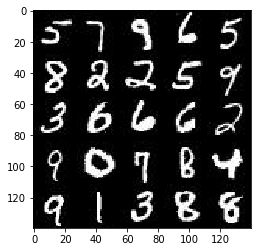

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

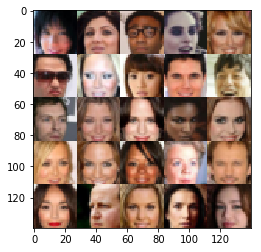

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    
    lr = tf.placeholder(tf.float32, name="lr")

    return inputs_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.01, training = True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    print("------------\n", "Discriminator\n", "------------\n")
    print("params: reuse - {}\n".format(reuse))
    
    with tf.variable_scope("discriminator", reuse=reuse):
        images_input = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        images_input = tf.maximum(alpha*images_input, images_input)
        
        print("Conv1 - ", images_input.shape)
        
        c2 = tf.layers.batch_normalization(tf.layers.conv2d(images_input, 128, 5, strides=2, padding='same'),
                                           training=training)
        c2 = tf.maximum(alpha * c2, c2)
        
        print("Conv2 - ", c2.shape)
        
        c3 = tf.layers.batch_normalization(tf.layers.conv2d(c2, 256, 5, strides=2, padding='same'),
                                           training=training)
        c3 = tf.maximum(alpha * c3, c3)
        
        print("Conv3 - ", c3.shape)
        
        flat = tf.reshape(c3, (-1, 4*4*256))
        
        print("Flat - ", flat.shape)
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        print("Logits - ", logits.shape, '\n')
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

------------
 Discriminator
 ------------

params: reuse - False

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

------------
 Discriminator
 ------------

params: reuse - True

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    print("------------\n", "Generator\n", "------------\n")
    
    with tf.variable_scope('generator', reuse=(False if is_train else True)):
        z_input = tf.layers.dense(z, 7 * 7 * 256)
        z_input = tf.reshape(z_input, (-1, 7, 7, 256))
        z_input = tf.layers.batch_normalization(z_input, training=is_train)
        z_input = tf.maximum(alpha * z_input, z_input)
        
        print("Dense", z_input.shape)
        
        #Transpose Convolutional Layer with Batch normalization
        c1 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(z_input, filters=128, 
                                                                      kernel_size=5, strides=2, 
                                                                      padding='same'), 
                                           training=is_train)
        #Leaky ReLu
        c1 = tf.maximum(alpha*c1, c1)
        
        print("Conv1 - ", c1.shape)
        
        c2 = tf.layers.batch_normalization(tf.layers.conv2d_transpose(c1, filters=64, 
                                                                      kernel_size=5, strides=2, 
                                                                      padding='same'), 
                                           training=is_train)
        c2 = tf.maximum(alpha*c2, c2)
        
        print("Conv2 - ", c2.shape)
        
        
        logits = tf.layers.conv2d_transpose(c2, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        
        print("Logits - ", logits.shape, '\n')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 5) 

------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 5) 

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # Adding label smoothing, to improve performance.
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 4) 

------------
 Discriminator
 ------------

params: reuse - False

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

------------
 Discriminator
 ------------

params: reuse - True

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Building DCGAN

In [10]:
class DCGAN:
    def __init__(self, image_real_size, z_size, learning_rate, alpha=0.01, beta1=0.5):
        # tf.reset_default_graph()
        
        self.input_real, self.input_z, self.lr = model_inputs(*image_real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              image_real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = list(input_z.shape)[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.01):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    print_every=10
    show_every=100
    
    net = DCGAN(data_shape[1:],
                z_dim,
                learning_rate, 
                alpha=alpha,
                beta1=beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Normalising image ranges since the values of the MNIST and CelebA dataset 
                # are in the range of -0.5 to 0.5
                batch_images = batch_images * 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Steps {}: ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    samples.append(show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode))

        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 

------------
 Discriminator
 ------------

params: reuse - False

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

------------
 Discriminator
 ------------

params: reuse - True

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

Epoch 1/2... Steps 10:  Discriminator Loss: 1.6597... Generator Loss: 5.0542
Epoch 1/2... Steps 20:  Discriminator Loss: 1.1916... Generator Loss: 0.6919
Epoch 1/2... Steps 30:  Discriminator Loss: 2.8841... Generator Loss: 0.1381
Epoch 1/2... Steps 40:  Discriminator Loss: 0.6105... Generator Loss: 3.1570
Epoch 1/2... Steps 50:  Discriminator Loss: 0.7903... Generator Loss: 1.5692
Epoch 1/2... Steps 60:  Discriminator Loss: 1.7345... Generator Loss: 0.3869
Epoch 1/2... Steps 70:  Discriminator Loss: 1.148

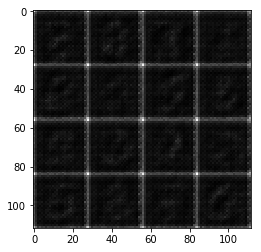

Epoch 1/2... Steps 110:  Discriminator Loss: 1.2278... Generator Loss: 0.7077
Epoch 1/2... Steps 120:  Discriminator Loss: 0.9328... Generator Loss: 1.2056
Epoch 1/2... Steps 130:  Discriminator Loss: 1.1352... Generator Loss: 0.7378
Epoch 1/2... Steps 140:  Discriminator Loss: 1.1078... Generator Loss: 0.7744
Epoch 1/2... Steps 150:  Discriminator Loss: 0.9580... Generator Loss: 1.0975
Epoch 1/2... Steps 160:  Discriminator Loss: 0.9881... Generator Loss: 0.9794
Epoch 1/2... Steps 170:  Discriminator Loss: 1.0089... Generator Loss: 1.6927
Epoch 1/2... Steps 180:  Discriminator Loss: 0.8666... Generator Loss: 1.6796
Epoch 1/2... Steps 190:  Discriminator Loss: 0.9732... Generator Loss: 1.0479
Epoch 1/2... Steps 200:  Discriminator Loss: 1.0694... Generator Loss: 0.7916
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



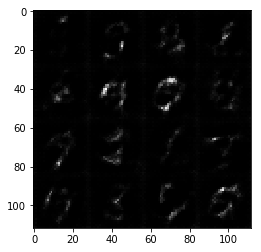

Epoch 1/2... Steps 210:  Discriminator Loss: 0.8382... Generator Loss: 1.2781
Epoch 1/2... Steps 220:  Discriminator Loss: 1.2310... Generator Loss: 0.6654
Epoch 1/2... Steps 230:  Discriminator Loss: 1.0661... Generator Loss: 0.8193
Epoch 1/2... Steps 240:  Discriminator Loss: 0.9773... Generator Loss: 0.9826
Epoch 1/2... Steps 250:  Discriminator Loss: 1.0488... Generator Loss: 1.1786
Epoch 1/2... Steps 260:  Discriminator Loss: 1.3993... Generator Loss: 0.5293
Epoch 1/2... Steps 270:  Discriminator Loss: 1.1013... Generator Loss: 0.7729
Epoch 1/2... Steps 280:  Discriminator Loss: 0.9917... Generator Loss: 1.8031
Epoch 1/2... Steps 290:  Discriminator Loss: 0.9307... Generator Loss: 1.4116
Epoch 1/2... Steps 300:  Discriminator Loss: 0.9763... Generator Loss: 1.1503
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



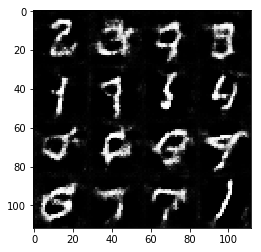

Epoch 1/2... Steps 310:  Discriminator Loss: 0.9679... Generator Loss: 1.1217
Epoch 1/2... Steps 320:  Discriminator Loss: 0.8843... Generator Loss: 1.2487
Epoch 1/2... Steps 330:  Discriminator Loss: 1.4931... Generator Loss: 0.4795
Epoch 1/2... Steps 340:  Discriminator Loss: 1.0448... Generator Loss: 1.3744
Epoch 1/2... Steps 350:  Discriminator Loss: 0.9839... Generator Loss: 1.0432
Epoch 1/2... Steps 360:  Discriminator Loss: 1.3982... Generator Loss: 0.5230
Epoch 1/2... Steps 370:  Discriminator Loss: 1.0578... Generator Loss: 0.8901
Epoch 1/2... Steps 380:  Discriminator Loss: 1.0054... Generator Loss: 0.9716
Epoch 1/2... Steps 390:  Discriminator Loss: 0.8637... Generator Loss: 1.2606
Epoch 1/2... Steps 400:  Discriminator Loss: 0.9868... Generator Loss: 1.1979
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



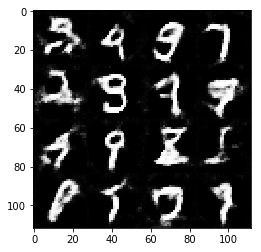

Epoch 1/2... Steps 410:  Discriminator Loss: 0.9897... Generator Loss: 0.9793
Epoch 1/2... Steps 420:  Discriminator Loss: 1.1619... Generator Loss: 0.7590
Epoch 1/2... Steps 430:  Discriminator Loss: 1.3949... Generator Loss: 0.5799
Epoch 1/2... Steps 440:  Discriminator Loss: 1.0995... Generator Loss: 0.7869
Epoch 1/2... Steps 450:  Discriminator Loss: 1.2869... Generator Loss: 0.6125
Epoch 1/2... Steps 460:  Discriminator Loss: 1.0765... Generator Loss: 0.8162
Epoch 1/2... Steps 470:  Discriminator Loss: 0.9461... Generator Loss: 1.1064
Epoch 1/2... Steps 480:  Discriminator Loss: 1.6120... Generator Loss: 2.9145
Epoch 1/2... Steps 490:  Discriminator Loss: 0.9580... Generator Loss: 1.3067
Epoch 1/2... Steps 500:  Discriminator Loss: 1.2517... Generator Loss: 2.0246
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



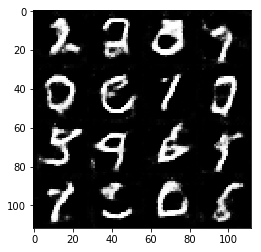

Epoch 1/2... Steps 510:  Discriminator Loss: 0.8414... Generator Loss: 1.7454
Epoch 1/2... Steps 520:  Discriminator Loss: 0.9324... Generator Loss: 1.0069
Epoch 1/2... Steps 530:  Discriminator Loss: 1.2008... Generator Loss: 0.6746
Epoch 1/2... Steps 540:  Discriminator Loss: 0.9428... Generator Loss: 1.2463
Epoch 1/2... Steps 550:  Discriminator Loss: 1.0271... Generator Loss: 1.5154
Epoch 1/2... Steps 560:  Discriminator Loss: 1.0049... Generator Loss: 0.9332
Epoch 1/2... Steps 570:  Discriminator Loss: 1.2670... Generator Loss: 0.5900
Epoch 1/2... Steps 580:  Discriminator Loss: 0.9862... Generator Loss: 0.9067
Epoch 1/2... Steps 590:  Discriminator Loss: 0.9271... Generator Loss: 1.7663
Epoch 1/2... Steps 600:  Discriminator Loss: 1.0713... Generator Loss: 0.9468
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



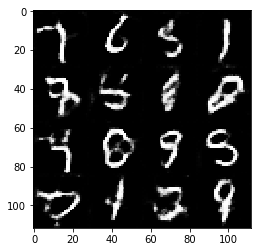

Epoch 1/2... Steps 610:  Discriminator Loss: 1.2798... Generator Loss: 0.6536
Epoch 1/2... Steps 620:  Discriminator Loss: 0.8619... Generator Loss: 1.3530
Epoch 1/2... Steps 630:  Discriminator Loss: 1.5828... Generator Loss: 0.4378
Epoch 1/2... Steps 640:  Discriminator Loss: 1.0636... Generator Loss: 0.8420
Epoch 1/2... Steps 650:  Discriminator Loss: 0.8887... Generator Loss: 1.0740
Epoch 1/2... Steps 660:  Discriminator Loss: 1.2655... Generator Loss: 0.6312
Epoch 1/2... Steps 670:  Discriminator Loss: 0.8916... Generator Loss: 1.2531
Epoch 1/2... Steps 680:  Discriminator Loss: 0.9395... Generator Loss: 1.3705
Epoch 1/2... Steps 690:  Discriminator Loss: 1.1533... Generator Loss: 0.8320
Epoch 1/2... Steps 700:  Discriminator Loss: 0.8898... Generator Loss: 1.3714
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



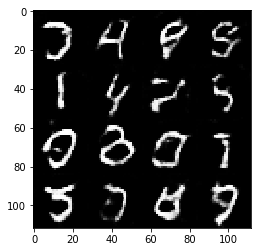

Epoch 1/2... Steps 710:  Discriminator Loss: 0.9740... Generator Loss: 1.2000
Epoch 1/2... Steps 720:  Discriminator Loss: 1.0008... Generator Loss: 0.9799
Epoch 1/2... Steps 730:  Discriminator Loss: 1.8702... Generator Loss: 0.3256
Epoch 1/2... Steps 740:  Discriminator Loss: 1.0635... Generator Loss: 0.9373
Epoch 1/2... Steps 750:  Discriminator Loss: 1.3203... Generator Loss: 0.5789
Epoch 1/2... Steps 760:  Discriminator Loss: 0.9018... Generator Loss: 2.0136
Epoch 1/2... Steps 770:  Discriminator Loss: 0.9679... Generator Loss: 1.1978
Epoch 1/2... Steps 780:  Discriminator Loss: 0.9403... Generator Loss: 0.9799
Epoch 1/2... Steps 790:  Discriminator Loss: 1.0736... Generator Loss: 1.6922
Epoch 1/2... Steps 800:  Discriminator Loss: 1.0877... Generator Loss: 0.8633
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



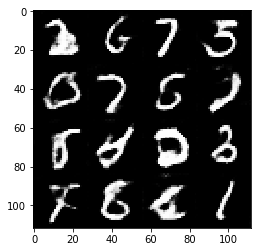

Epoch 1/2... Steps 810:  Discriminator Loss: 0.8401... Generator Loss: 1.7502
Epoch 1/2... Steps 820:  Discriminator Loss: 0.9633... Generator Loss: 1.5430
Epoch 1/2... Steps 830:  Discriminator Loss: 0.9114... Generator Loss: 1.0942
Epoch 1/2... Steps 840:  Discriminator Loss: 0.8840... Generator Loss: 1.1837
Epoch 1/2... Steps 850:  Discriminator Loss: 1.0094... Generator Loss: 1.0079
Epoch 1/2... Steps 860:  Discriminator Loss: 0.8835... Generator Loss: 2.1047
Epoch 1/2... Steps 870:  Discriminator Loss: 2.8127... Generator Loss: 3.4629
Epoch 1/2... Steps 880:  Discriminator Loss: 1.0133... Generator Loss: 0.8681
Epoch 1/2... Steps 890:  Discriminator Loss: 0.8674... Generator Loss: 1.7182
Epoch 1/2... Steps 900:  Discriminator Loss: 0.9930... Generator Loss: 0.9216
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



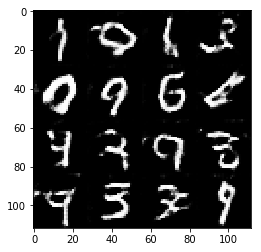

Epoch 1/2... Steps 910:  Discriminator Loss: 0.9255... Generator Loss: 1.0620
Epoch 1/2... Steps 920:  Discriminator Loss: 1.2569... Generator Loss: 0.6630
Epoch 1/2... Steps 930:  Discriminator Loss: 0.8813... Generator Loss: 1.1897
Epoch 2/2... Steps 940:  Discriminator Loss: 0.9866... Generator Loss: 1.6602
Epoch 2/2... Steps 950:  Discriminator Loss: 0.9386... Generator Loss: 1.0284
Epoch 2/2... Steps 960:  Discriminator Loss: 1.1343... Generator Loss: 0.8118
Epoch 2/2... Steps 970:  Discriminator Loss: 1.1150... Generator Loss: 2.0088
Epoch 2/2... Steps 980:  Discriminator Loss: 0.8083... Generator Loss: 1.4844
Epoch 2/2... Steps 990:  Discriminator Loss: 0.8868... Generator Loss: 1.1195
Epoch 2/2... Steps 1000:  Discriminator Loss: 1.0337... Generator Loss: 1.5882
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



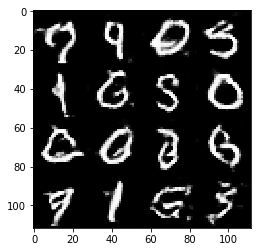

Epoch 2/2... Steps 1010:  Discriminator Loss: 0.8723... Generator Loss: 1.1291
Epoch 2/2... Steps 1020:  Discriminator Loss: 0.9031... Generator Loss: 1.0672
Epoch 2/2... Steps 1030:  Discriminator Loss: 1.0086... Generator Loss: 0.9214
Epoch 2/2... Steps 1040:  Discriminator Loss: 1.1008... Generator Loss: 0.8585
Epoch 2/2... Steps 1050:  Discriminator Loss: 1.0367... Generator Loss: 1.0115
Epoch 2/2... Steps 1060:  Discriminator Loss: 1.0109... Generator Loss: 1.1081
Epoch 2/2... Steps 1070:  Discriminator Loss: 1.0618... Generator Loss: 0.8485
Epoch 2/2... Steps 1080:  Discriminator Loss: 1.2489... Generator Loss: 0.5964
Epoch 2/2... Steps 1090:  Discriminator Loss: 0.9366... Generator Loss: 0.9786
Epoch 2/2... Steps 1100:  Discriminator Loss: 1.2070... Generator Loss: 2.4728
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



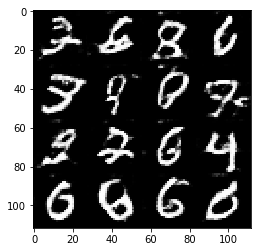

Epoch 2/2... Steps 1110:  Discriminator Loss: 0.8263... Generator Loss: 1.7464
Epoch 2/2... Steps 1120:  Discriminator Loss: 0.9089... Generator Loss: 1.1635
Epoch 2/2... Steps 1130:  Discriminator Loss: 0.7762... Generator Loss: 1.5646
Epoch 2/2... Steps 1140:  Discriminator Loss: 0.8591... Generator Loss: 1.5870
Epoch 2/2... Steps 1150:  Discriminator Loss: 0.8929... Generator Loss: 1.1286
Epoch 2/2... Steps 1160:  Discriminator Loss: 0.9135... Generator Loss: 0.9685
Epoch 2/2... Steps 1170:  Discriminator Loss: 1.0520... Generator Loss: 0.8314
Epoch 2/2... Steps 1180:  Discriminator Loss: 1.2142... Generator Loss: 0.6845
Epoch 2/2... Steps 1190:  Discriminator Loss: 1.2157... Generator Loss: 0.6640
Epoch 2/2... Steps 1200:  Discriminator Loss: 0.9857... Generator Loss: 1.2870
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



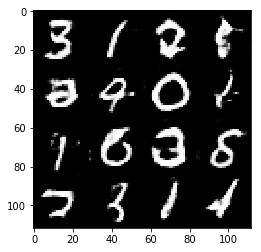

Epoch 2/2... Steps 1210:  Discriminator Loss: 0.8429... Generator Loss: 1.2954
Epoch 2/2... Steps 1220:  Discriminator Loss: 0.9799... Generator Loss: 0.9792
Epoch 2/2... Steps 1230:  Discriminator Loss: 0.8318... Generator Loss: 1.3132
Epoch 2/2... Steps 1240:  Discriminator Loss: 0.7448... Generator Loss: 1.6663
Epoch 2/2... Steps 1250:  Discriminator Loss: 0.6834... Generator Loss: 1.5829
Epoch 2/2... Steps 1260:  Discriminator Loss: 1.2778... Generator Loss: 2.9812
Epoch 2/2... Steps 1270:  Discriminator Loss: 1.8208... Generator Loss: 0.3744
Epoch 2/2... Steps 1280:  Discriminator Loss: 0.9913... Generator Loss: 0.9617
Epoch 2/2... Steps 1290:  Discriminator Loss: 1.3182... Generator Loss: 0.7647
Epoch 2/2... Steps 1300:  Discriminator Loss: 0.8192... Generator Loss: 1.6651
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



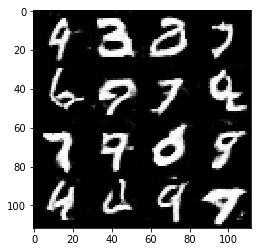

Epoch 2/2... Steps 1310:  Discriminator Loss: 0.9173... Generator Loss: 1.9518
Epoch 2/2... Steps 1320:  Discriminator Loss: 0.8929... Generator Loss: 1.2226
Epoch 2/2... Steps 1330:  Discriminator Loss: 0.7973... Generator Loss: 1.3479
Epoch 2/2... Steps 1340:  Discriminator Loss: 1.0804... Generator Loss: 0.8494
Epoch 2/2... Steps 1350:  Discriminator Loss: 0.8734... Generator Loss: 1.1395
Epoch 2/2... Steps 1360:  Discriminator Loss: 0.8560... Generator Loss: 1.1057
Epoch 2/2... Steps 1370:  Discriminator Loss: 0.9522... Generator Loss: 1.2268
Epoch 2/2... Steps 1380:  Discriminator Loss: 0.7056... Generator Loss: 1.9489
Epoch 2/2... Steps 1390:  Discriminator Loss: 1.3394... Generator Loss: 0.6785
Epoch 2/2... Steps 1400:  Discriminator Loss: 0.9257... Generator Loss: 1.1488
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



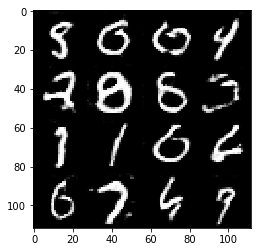

Epoch 2/2... Steps 1410:  Discriminator Loss: 0.8048... Generator Loss: 1.2565
Epoch 2/2... Steps 1420:  Discriminator Loss: 0.7639... Generator Loss: 1.8634
Epoch 2/2... Steps 1430:  Discriminator Loss: 0.8596... Generator Loss: 1.2126
Epoch 2/2... Steps 1440:  Discriminator Loss: 1.2699... Generator Loss: 2.6206
Epoch 2/2... Steps 1450:  Discriminator Loss: 1.0317... Generator Loss: 0.8970
Epoch 2/2... Steps 1460:  Discriminator Loss: 0.6758... Generator Loss: 1.6905
Epoch 2/2... Steps 1470:  Discriminator Loss: 0.6846... Generator Loss: 2.0882
Epoch 2/2... Steps 1480:  Discriminator Loss: 0.8018... Generator Loss: 2.6661
Epoch 2/2... Steps 1490:  Discriminator Loss: 1.0553... Generator Loss: 0.8538
Epoch 2/2... Steps 1500:  Discriminator Loss: 1.0484... Generator Loss: 0.8478
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



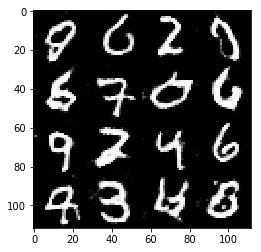

Epoch 2/2... Steps 1510:  Discriminator Loss: 0.9091... Generator Loss: 1.0723
Epoch 2/2... Steps 1520:  Discriminator Loss: 1.2116... Generator Loss: 0.6783
Epoch 2/2... Steps 1530:  Discriminator Loss: 0.6410... Generator Loss: 1.9793
Epoch 2/2... Steps 1540:  Discriminator Loss: 1.0676... Generator Loss: 0.8265
Epoch 2/2... Steps 1550:  Discriminator Loss: 0.6698... Generator Loss: 1.6551
Epoch 2/2... Steps 1560:  Discriminator Loss: 0.7380... Generator Loss: 1.8495
Epoch 2/2... Steps 1570:  Discriminator Loss: 1.2044... Generator Loss: 2.6392
Epoch 2/2... Steps 1580:  Discriminator Loss: 1.2113... Generator Loss: 0.6961
Epoch 2/2... Steps 1590:  Discriminator Loss: 0.8220... Generator Loss: 1.4662
Epoch 2/2... Steps 1600:  Discriminator Loss: 0.8605... Generator Loss: 1.1493
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



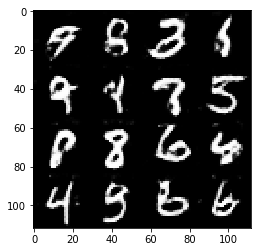

Epoch 2/2... Steps 1610:  Discriminator Loss: 0.6955... Generator Loss: 2.0258
Epoch 2/2... Steps 1620:  Discriminator Loss: 0.8448... Generator Loss: 1.4448
Epoch 2/2... Steps 1630:  Discriminator Loss: 1.6925... Generator Loss: 0.4456
Epoch 2/2... Steps 1640:  Discriminator Loss: 0.8886... Generator Loss: 1.1102
Epoch 2/2... Steps 1650:  Discriminator Loss: 1.1725... Generator Loss: 0.7634
Epoch 2/2... Steps 1660:  Discriminator Loss: 0.8175... Generator Loss: 1.2137
Epoch 2/2... Steps 1670:  Discriminator Loss: 0.8194... Generator Loss: 1.1986
Epoch 2/2... Steps 1680:  Discriminator Loss: 0.8860... Generator Loss: 2.3756
Epoch 2/2... Steps 1690:  Discriminator Loss: 0.8465... Generator Loss: 1.1939
Epoch 2/2... Steps 1700:  Discriminator Loss: 1.2400... Generator Loss: 0.6902
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



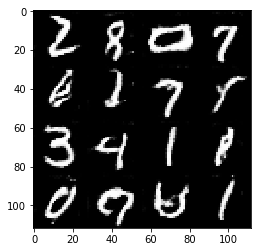

Epoch 2/2... Steps 1710:  Discriminator Loss: 1.1907... Generator Loss: 0.6831
Epoch 2/2... Steps 1720:  Discriminator Loss: 0.6609... Generator Loss: 1.6889
Epoch 2/2... Steps 1730:  Discriminator Loss: 0.7327... Generator Loss: 1.6441
Epoch 2/2... Steps 1740:  Discriminator Loss: 0.9144... Generator Loss: 1.2137
Epoch 2/2... Steps 1750:  Discriminator Loss: 1.1877... Generator Loss: 0.7657
Epoch 2/2... Steps 1760:  Discriminator Loss: 1.1429... Generator Loss: 1.4115
Epoch 2/2... Steps 1770:  Discriminator Loss: 0.7968... Generator Loss: 1.6943
Epoch 2/2... Steps 1780:  Discriminator Loss: 1.0074... Generator Loss: 0.8866
Epoch 2/2... Steps 1790:  Discriminator Loss: 1.0126... Generator Loss: 2.2847
Epoch 2/2... Steps 1800:  Discriminator Loss: 0.9502... Generator Loss: 1.2362
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 1) 



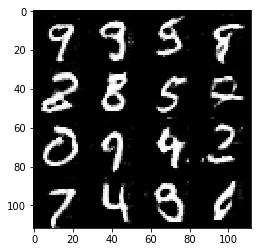

Epoch 2/2... Steps 1810:  Discriminator Loss: 0.7078... Generator Loss: 1.6834
Epoch 2/2... Steps 1820:  Discriminator Loss: 1.0421... Generator Loss: 2.7120
Epoch 2/2... Steps 1830:  Discriminator Loss: 0.6911... Generator Loss: 1.6694
Epoch 2/2... Steps 1840:  Discriminator Loss: 0.6663... Generator Loss: 1.5754
Epoch 2/2... Steps 1850:  Discriminator Loss: 0.9073... Generator Loss: 1.0177
Epoch 2/2... Steps 1860:  Discriminator Loss: 0.8654... Generator Loss: 1.0879
Epoch 2/2... Steps 1870:  Discriminator Loss: 1.2643... Generator Loss: 0.6615


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5
alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 

------------
 Discriminator
 ------------

params: reuse - False

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

------------
 Discriminator
 ------------

params: reuse - True

Conv1 -  (?, 14, 14, 64)
Conv2 -  (?, 7, 7, 128)
Conv3 -  (?, 4, 4, 256)
Flat -  (?, 4096)
Logits -  (?, 1) 

Epoch 1/1... Steps 10:  Discriminator Loss: 0.8785... Generator Loss: 1.1261
Epoch 1/1... Steps 20:  Discriminator Loss: 0.9886... Generator Loss: 12.4437
Epoch 1/1... Steps 30:  Discriminator Loss: 0.6503... Generator Loss: 2.3513
Epoch 1/1... Steps 40:  Discriminator Loss: 1.1198... Generator Loss: 2.8001
Epoch 1/1... Steps 50:  Discriminator Loss: 0.7246... Generator Loss: 1.4416
Epoch 1/1... Steps 60:  Discriminator Loss: 0.7304... Generator Loss: 1.7823
Epoch 1/1... Steps 70:  Discriminator Loss: 0.81

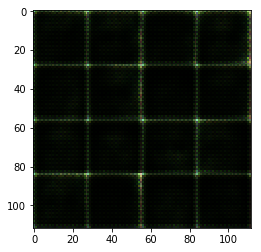

Epoch 1/1... Steps 110:  Discriminator Loss: 0.7969... Generator Loss: 1.2317
Epoch 1/1... Steps 120:  Discriminator Loss: 0.7766... Generator Loss: 1.2911
Epoch 1/1... Steps 130:  Discriminator Loss: 0.8741... Generator Loss: 3.3030
Epoch 1/1... Steps 140:  Discriminator Loss: 0.6711... Generator Loss: 1.8892
Epoch 1/1... Steps 150:  Discriminator Loss: 1.3733... Generator Loss: 3.3318
Epoch 1/1... Steps 160:  Discriminator Loss: 1.8832... Generator Loss: 4.5100
Epoch 1/1... Steps 170:  Discriminator Loss: 0.9923... Generator Loss: 0.8611
Epoch 1/1... Steps 180:  Discriminator Loss: 0.8106... Generator Loss: 1.2850
Epoch 1/1... Steps 190:  Discriminator Loss: 0.5312... Generator Loss: 2.1645
Epoch 1/1... Steps 200:  Discriminator Loss: 0.5860... Generator Loss: 3.3739
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



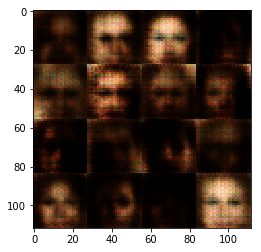

Epoch 1/1... Steps 210:  Discriminator Loss: 0.7939... Generator Loss: 1.2260
Epoch 1/1... Steps 220:  Discriminator Loss: 0.7717... Generator Loss: 2.3446
Epoch 1/1... Steps 230:  Discriminator Loss: 1.0143... Generator Loss: 1.2419
Epoch 1/1... Steps 240:  Discriminator Loss: 1.1291... Generator Loss: 0.7514
Epoch 1/1... Steps 250:  Discriminator Loss: 0.6395... Generator Loss: 2.5538
Epoch 1/1... Steps 260:  Discriminator Loss: 1.1737... Generator Loss: 0.8081
Epoch 1/1... Steps 270:  Discriminator Loss: 0.7091... Generator Loss: 1.4404
Epoch 1/1... Steps 280:  Discriminator Loss: 0.6580... Generator Loss: 2.4709
Epoch 1/1... Steps 290:  Discriminator Loss: 0.5908... Generator Loss: 2.3918
Epoch 1/1... Steps 300:  Discriminator Loss: 0.9768... Generator Loss: 1.2989
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



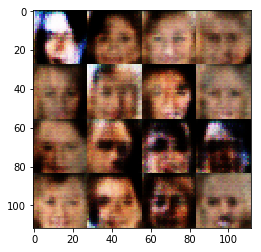

Epoch 1/1... Steps 310:  Discriminator Loss: 0.8345... Generator Loss: 2.0079
Epoch 1/1... Steps 320:  Discriminator Loss: 0.7795... Generator Loss: 1.8705
Epoch 1/1... Steps 330:  Discriminator Loss: 0.7624... Generator Loss: 1.6542
Epoch 1/1... Steps 340:  Discriminator Loss: 1.2019... Generator Loss: 0.9442
Epoch 1/1... Steps 350:  Discriminator Loss: 1.1730... Generator Loss: 2.5322
Epoch 1/1... Steps 360:  Discriminator Loss: 1.6052... Generator Loss: 0.4077
Epoch 1/1... Steps 370:  Discriminator Loss: 0.9086... Generator Loss: 1.6103
Epoch 1/1... Steps 380:  Discriminator Loss: 1.1281... Generator Loss: 1.1238
Epoch 1/1... Steps 390:  Discriminator Loss: 1.0592... Generator Loss: 4.4945
Epoch 1/1... Steps 400:  Discriminator Loss: 0.5512... Generator Loss: 2.2576
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



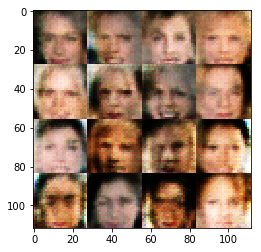

Epoch 1/1... Steps 410:  Discriminator Loss: 1.0856... Generator Loss: 0.9615
Epoch 1/1... Steps 420:  Discriminator Loss: 0.6511... Generator Loss: 1.8552
Epoch 1/1... Steps 430:  Discriminator Loss: 1.1083... Generator Loss: 0.7553
Epoch 1/1... Steps 440:  Discriminator Loss: 0.8796... Generator Loss: 1.1963
Epoch 1/1... Steps 450:  Discriminator Loss: 1.6662... Generator Loss: 3.4874
Epoch 1/1... Steps 460:  Discriminator Loss: 1.1110... Generator Loss: 1.7306
Epoch 1/1... Steps 470:  Discriminator Loss: 1.4694... Generator Loss: 0.4930
Epoch 1/1... Steps 480:  Discriminator Loss: 0.6543... Generator Loss: 1.5535
Epoch 1/1... Steps 490:  Discriminator Loss: 1.2348... Generator Loss: 0.7297
Epoch 1/1... Steps 500:  Discriminator Loss: 1.3344... Generator Loss: 3.4907
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



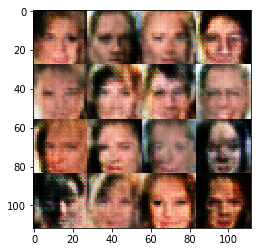

Epoch 1/1... Steps 510:  Discriminator Loss: 0.6739... Generator Loss: 3.3505
Epoch 1/1... Steps 520:  Discriminator Loss: 1.1581... Generator Loss: 0.7070
Epoch 1/1... Steps 530:  Discriminator Loss: 1.1219... Generator Loss: 0.7530
Epoch 1/1... Steps 540:  Discriminator Loss: 0.7061... Generator Loss: 1.4607
Epoch 1/1... Steps 550:  Discriminator Loss: 0.9994... Generator Loss: 0.8908
Epoch 1/1... Steps 560:  Discriminator Loss: 0.7664... Generator Loss: 1.5605
Epoch 1/1... Steps 570:  Discriminator Loss: 1.1509... Generator Loss: 0.9070
Epoch 1/1... Steps 580:  Discriminator Loss: 0.9368... Generator Loss: 1.0616
Epoch 1/1... Steps 590:  Discriminator Loss: 1.3329... Generator Loss: 0.5635
Epoch 1/1... Steps 600:  Discriminator Loss: 1.1412... Generator Loss: 0.9775
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



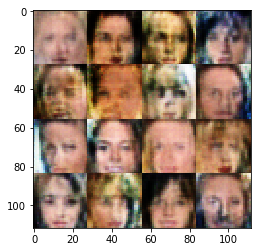

Epoch 1/1... Steps 610:  Discriminator Loss: 0.9834... Generator Loss: 1.1193
Epoch 1/1... Steps 620:  Discriminator Loss: 0.8420... Generator Loss: 1.1944
Epoch 1/1... Steps 630:  Discriminator Loss: 0.9226... Generator Loss: 1.2127
Epoch 1/1... Steps 640:  Discriminator Loss: 1.8652... Generator Loss: 3.2793
Epoch 1/1... Steps 650:  Discriminator Loss: 1.1392... Generator Loss: 0.7505
Epoch 1/1... Steps 660:  Discriminator Loss: 1.6501... Generator Loss: 0.4032
Epoch 1/1... Steps 670:  Discriminator Loss: 1.1887... Generator Loss: 1.3195
Epoch 1/1... Steps 680:  Discriminator Loss: 1.0890... Generator Loss: 0.9025
Epoch 1/1... Steps 690:  Discriminator Loss: 1.6486... Generator Loss: 0.3729
Epoch 1/1... Steps 700:  Discriminator Loss: 1.2055... Generator Loss: 0.7102
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



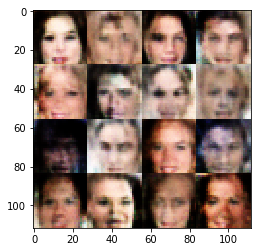

Epoch 1/1... Steps 710:  Discriminator Loss: 0.8777... Generator Loss: 1.0500
Epoch 1/1... Steps 720:  Discriminator Loss: 1.2074... Generator Loss: 1.3175
Epoch 1/1... Steps 730:  Discriminator Loss: 2.0287... Generator Loss: 3.9644
Epoch 1/1... Steps 740:  Discriminator Loss: 0.6219... Generator Loss: 2.0196
Epoch 1/1... Steps 750:  Discriminator Loss: 1.7483... Generator Loss: 0.3335
Epoch 1/1... Steps 760:  Discriminator Loss: 1.0058... Generator Loss: 0.8735
Epoch 1/1... Steps 770:  Discriminator Loss: 0.9942... Generator Loss: 1.9534
Epoch 1/1... Steps 780:  Discriminator Loss: 1.2936... Generator Loss: 0.6149
Epoch 1/1... Steps 790:  Discriminator Loss: 2.2907... Generator Loss: 3.8273
Epoch 1/1... Steps 800:  Discriminator Loss: 1.0439... Generator Loss: 1.1555
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



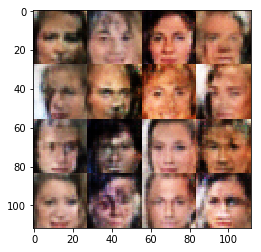

Epoch 1/1... Steps 810:  Discriminator Loss: 1.1172... Generator Loss: 2.1380
Epoch 1/1... Steps 820:  Discriminator Loss: 1.0079... Generator Loss: 1.5165
Epoch 1/1... Steps 830:  Discriminator Loss: 1.4107... Generator Loss: 0.5113
Epoch 1/1... Steps 840:  Discriminator Loss: 1.1754... Generator Loss: 0.6952
Epoch 1/1... Steps 850:  Discriminator Loss: 1.1385... Generator Loss: 0.7271
Epoch 1/1... Steps 860:  Discriminator Loss: 1.2170... Generator Loss: 0.6922
Epoch 1/1... Steps 870:  Discriminator Loss: 1.7488... Generator Loss: 0.3213
Epoch 1/1... Steps 880:  Discriminator Loss: 1.0599... Generator Loss: 0.8666
Epoch 1/1... Steps 890:  Discriminator Loss: 0.7051... Generator Loss: 1.7460
Epoch 1/1... Steps 900:  Discriminator Loss: 1.2540... Generator Loss: 1.9127
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



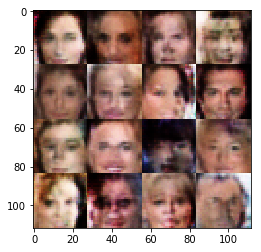

Epoch 1/1... Steps 910:  Discriminator Loss: 1.0664... Generator Loss: 0.9152
Epoch 1/1... Steps 920:  Discriminator Loss: 1.1248... Generator Loss: 1.5361
Epoch 1/1... Steps 930:  Discriminator Loss: 1.0008... Generator Loss: 2.4422
Epoch 1/1... Steps 940:  Discriminator Loss: 0.9878... Generator Loss: 1.1345
Epoch 1/1... Steps 950:  Discriminator Loss: 1.1182... Generator Loss: 0.9677
Epoch 1/1... Steps 960:  Discriminator Loss: 1.0077... Generator Loss: 0.9863
Epoch 1/1... Steps 970:  Discriminator Loss: 1.8304... Generator Loss: 0.3017
Epoch 1/1... Steps 980:  Discriminator Loss: 1.0149... Generator Loss: 0.8284
Epoch 1/1... Steps 990:  Discriminator Loss: 0.9649... Generator Loss: 0.8671
Epoch 1/1... Steps 1000:  Discriminator Loss: 1.4735... Generator Loss: 0.4704
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



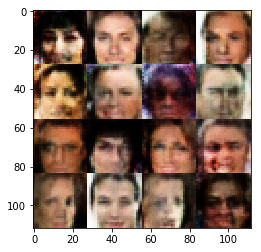

Epoch 1/1... Steps 1010:  Discriminator Loss: 1.1444... Generator Loss: 0.9705
Epoch 1/1... Steps 1020:  Discriminator Loss: 1.2161... Generator Loss: 0.7840
Epoch 1/1... Steps 1030:  Discriminator Loss: 1.0807... Generator Loss: 1.0373
Epoch 1/1... Steps 1040:  Discriminator Loss: 0.9101... Generator Loss: 1.1369
Epoch 1/1... Steps 1050:  Discriminator Loss: 1.4541... Generator Loss: 2.2871
Epoch 1/1... Steps 1060:  Discriminator Loss: 0.9140... Generator Loss: 1.4020
Epoch 1/1... Steps 1070:  Discriminator Loss: 1.0680... Generator Loss: 1.1316
Epoch 1/1... Steps 1080:  Discriminator Loss: 0.9758... Generator Loss: 0.9541
Epoch 1/1... Steps 1090:  Discriminator Loss: 0.9135... Generator Loss: 1.0693
Epoch 1/1... Steps 1100:  Discriminator Loss: 0.9710... Generator Loss: 1.1139
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



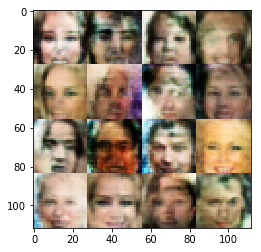

Epoch 1/1... Steps 1110:  Discriminator Loss: 0.8363... Generator Loss: 1.2230
Epoch 1/1... Steps 1120:  Discriminator Loss: 1.2360... Generator Loss: 1.4597
Epoch 1/1... Steps 1130:  Discriminator Loss: 1.3236... Generator Loss: 0.5584
Epoch 1/1... Steps 1140:  Discriminator Loss: 0.8912... Generator Loss: 0.9548
Epoch 1/1... Steps 1150:  Discriminator Loss: 1.3823... Generator Loss: 0.5331
Epoch 1/1... Steps 1160:  Discriminator Loss: 0.8705... Generator Loss: 1.7203
Epoch 1/1... Steps 1170:  Discriminator Loss: 0.7522... Generator Loss: 1.3681
Epoch 1/1... Steps 1180:  Discriminator Loss: 1.0767... Generator Loss: 1.7658
Epoch 1/1... Steps 1190:  Discriminator Loss: 0.9291... Generator Loss: 1.2725
Epoch 1/1... Steps 1200:  Discriminator Loss: 1.0116... Generator Loss: 0.8594
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



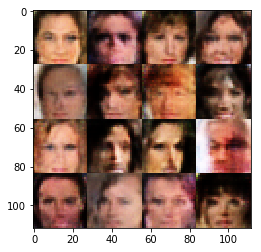

Epoch 1/1... Steps 1210:  Discriminator Loss: 1.1288... Generator Loss: 0.7458
Epoch 1/1... Steps 1220:  Discriminator Loss: 1.1679... Generator Loss: 0.7313
Epoch 1/1... Steps 1230:  Discriminator Loss: 1.0003... Generator Loss: 0.9150
Epoch 1/1... Steps 1240:  Discriminator Loss: 1.2142... Generator Loss: 0.6143
Epoch 1/1... Steps 1250:  Discriminator Loss: 1.0430... Generator Loss: 2.2638
Epoch 1/1... Steps 1260:  Discriminator Loss: 1.2464... Generator Loss: 0.7008
Epoch 1/1... Steps 1270:  Discriminator Loss: 0.9126... Generator Loss: 1.3901
Epoch 1/1... Steps 1280:  Discriminator Loss: 0.9808... Generator Loss: 0.9673
Epoch 1/1... Steps 1290:  Discriminator Loss: 0.7246... Generator Loss: 1.4692
Epoch 1/1... Steps 1300:  Discriminator Loss: 1.1584... Generator Loss: 1.0699
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



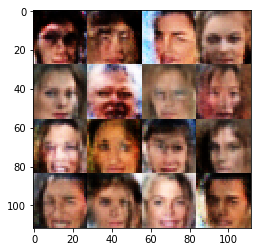

Epoch 1/1... Steps 1310:  Discriminator Loss: 1.2430... Generator Loss: 0.8364
Epoch 1/1... Steps 1320:  Discriminator Loss: 0.8050... Generator Loss: 1.2168
Epoch 1/1... Steps 1330:  Discriminator Loss: 0.8731... Generator Loss: 0.9994
Epoch 1/1... Steps 1340:  Discriminator Loss: 1.4185... Generator Loss: 0.4861
Epoch 1/1... Steps 1350:  Discriminator Loss: 0.6637... Generator Loss: 1.9460
Epoch 1/1... Steps 1360:  Discriminator Loss: 1.3328... Generator Loss: 0.5632
Epoch 1/1... Steps 1370:  Discriminator Loss: 1.3014... Generator Loss: 0.5876
Epoch 1/1... Steps 1380:  Discriminator Loss: 1.1419... Generator Loss: 0.6989
Epoch 1/1... Steps 1390:  Discriminator Loss: 0.8846... Generator Loss: 1.0864
Epoch 1/1... Steps 1400:  Discriminator Loss: 1.2595... Generator Loss: 0.6608
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



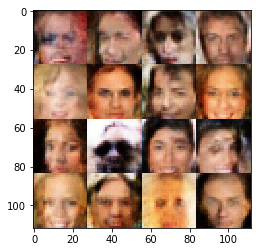

Epoch 1/1... Steps 1410:  Discriminator Loss: 1.0888... Generator Loss: 1.9998
Epoch 1/1... Steps 1420:  Discriminator Loss: 0.9538... Generator Loss: 1.4072
Epoch 1/1... Steps 1430:  Discriminator Loss: 1.1662... Generator Loss: 1.4634
Epoch 1/1... Steps 1440:  Discriminator Loss: 1.1593... Generator Loss: 0.6999
Epoch 1/1... Steps 1450:  Discriminator Loss: 1.0727... Generator Loss: 2.7284
Epoch 1/1... Steps 1460:  Discriminator Loss: 1.0664... Generator Loss: 1.0846
Epoch 1/1... Steps 1470:  Discriminator Loss: 0.8907... Generator Loss: 1.1722
Epoch 1/1... Steps 1480:  Discriminator Loss: 1.8568... Generator Loss: 0.2909
Epoch 1/1... Steps 1490:  Discriminator Loss: 1.1530... Generator Loss: 0.8429
Epoch 1/1... Steps 1500:  Discriminator Loss: 1.4093... Generator Loss: 1.9322
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



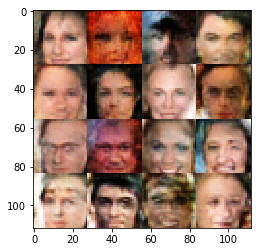

Epoch 1/1... Steps 1510:  Discriminator Loss: 1.1212... Generator Loss: 0.7587
Epoch 1/1... Steps 1520:  Discriminator Loss: 0.7970... Generator Loss: 1.1982
Epoch 1/1... Steps 1530:  Discriminator Loss: 1.8054... Generator Loss: 0.3172
Epoch 1/1... Steps 1540:  Discriminator Loss: 1.3645... Generator Loss: 0.5228
Epoch 1/1... Steps 1550:  Discriminator Loss: 1.2222... Generator Loss: 0.6354
Epoch 1/1... Steps 1560:  Discriminator Loss: 1.5637... Generator Loss: 3.0196
Epoch 1/1... Steps 1570:  Discriminator Loss: 1.4441... Generator Loss: 0.4830
Epoch 1/1... Steps 1580:  Discriminator Loss: 1.0449... Generator Loss: 0.9870
Epoch 1/1... Steps 1590:  Discriminator Loss: 1.6014... Generator Loss: 0.4660
Epoch 1/1... Steps 1600:  Discriminator Loss: 0.9474... Generator Loss: 1.3131
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



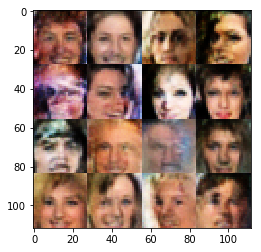

Epoch 1/1... Steps 1610:  Discriminator Loss: 1.0108... Generator Loss: 1.7779
Epoch 1/1... Steps 1620:  Discriminator Loss: 1.4049... Generator Loss: 0.5256
Epoch 1/1... Steps 1630:  Discriminator Loss: 1.0120... Generator Loss: 1.0221
Epoch 1/1... Steps 1640:  Discriminator Loss: 0.7749... Generator Loss: 1.2750
Epoch 1/1... Steps 1650:  Discriminator Loss: 0.9966... Generator Loss: 0.9033
Epoch 1/1... Steps 1660:  Discriminator Loss: 0.8716... Generator Loss: 1.1770
Epoch 1/1... Steps 1670:  Discriminator Loss: 1.4606... Generator Loss: 0.5489
Epoch 1/1... Steps 1680:  Discriminator Loss: 1.1283... Generator Loss: 1.4329
Epoch 1/1... Steps 1690:  Discriminator Loss: 1.0186... Generator Loss: 1.1845
Epoch 1/1... Steps 1700:  Discriminator Loss: 1.2671... Generator Loss: 0.5826
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



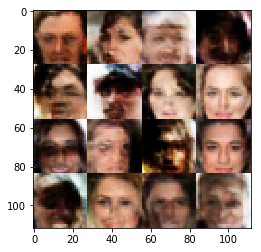

Epoch 1/1... Steps 1710:  Discriminator Loss: 1.1246... Generator Loss: 0.7755
Epoch 1/1... Steps 1720:  Discriminator Loss: 1.5850... Generator Loss: 0.4131
Epoch 1/1... Steps 1730:  Discriminator Loss: 1.3166... Generator Loss: 0.5413
Epoch 1/1... Steps 1740:  Discriminator Loss: 0.8242... Generator Loss: 2.1173
Epoch 1/1... Steps 1750:  Discriminator Loss: 0.9761... Generator Loss: 1.7610
Epoch 1/1... Steps 1760:  Discriminator Loss: 1.1620... Generator Loss: 0.6942
Epoch 1/1... Steps 1770:  Discriminator Loss: 1.6473... Generator Loss: 0.3827
Epoch 1/1... Steps 1780:  Discriminator Loss: 0.6879... Generator Loss: 2.0173
Epoch 1/1... Steps 1790:  Discriminator Loss: 1.0197... Generator Loss: 2.1475
Epoch 1/1... Steps 1800:  Discriminator Loss: 1.0540... Generator Loss: 0.9160
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



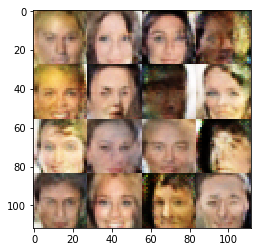

Epoch 1/1... Steps 1810:  Discriminator Loss: 1.0835... Generator Loss: 0.8329
Epoch 1/1... Steps 1820:  Discriminator Loss: 1.0994... Generator Loss: 0.8741
Epoch 1/1... Steps 1830:  Discriminator Loss: 1.0336... Generator Loss: 0.9114
Epoch 1/1... Steps 1840:  Discriminator Loss: 1.3268... Generator Loss: 0.8072
Epoch 1/1... Steps 1850:  Discriminator Loss: 2.3894... Generator Loss: 0.1684
Epoch 1/1... Steps 1860:  Discriminator Loss: 0.9919... Generator Loss: 1.0082
Epoch 1/1... Steps 1870:  Discriminator Loss: 1.5137... Generator Loss: 0.4496
Epoch 1/1... Steps 1880:  Discriminator Loss: 1.1208... Generator Loss: 1.4159
Epoch 1/1... Steps 1890:  Discriminator Loss: 1.0569... Generator Loss: 0.9496
Epoch 1/1... Steps 1900:  Discriminator Loss: 1.2635... Generator Loss: 0.7241
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



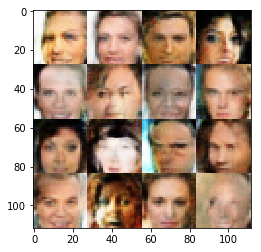

Epoch 1/1... Steps 1910:  Discriminator Loss: 1.2373... Generator Loss: 0.9592
Epoch 1/1... Steps 1920:  Discriminator Loss: 1.0760... Generator Loss: 0.8447
Epoch 1/1... Steps 1930:  Discriminator Loss: 0.9976... Generator Loss: 0.9068
Epoch 1/1... Steps 1940:  Discriminator Loss: 1.0585... Generator Loss: 0.7861
Epoch 1/1... Steps 1950:  Discriminator Loss: 1.5297... Generator Loss: 0.4453
Epoch 1/1... Steps 1960:  Discriminator Loss: 0.6398... Generator Loss: 2.1603
Epoch 1/1... Steps 1970:  Discriminator Loss: 1.0063... Generator Loss: 1.0278
Epoch 1/1... Steps 1980:  Discriminator Loss: 0.8142... Generator Loss: 1.6769
Epoch 1/1... Steps 1990:  Discriminator Loss: 1.3040... Generator Loss: 0.5785
Epoch 1/1... Steps 2000:  Discriminator Loss: 1.6454... Generator Loss: 0.3744
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



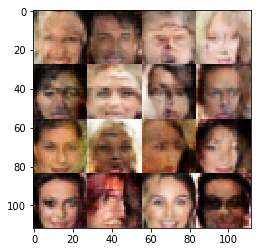

Epoch 1/1... Steps 2010:  Discriminator Loss: 1.6891... Generator Loss: 0.3628
Epoch 1/1... Steps 2020:  Discriminator Loss: 0.8325... Generator Loss: 1.3523
Epoch 1/1... Steps 2030:  Discriminator Loss: 1.4468... Generator Loss: 0.5193
Epoch 1/1... Steps 2040:  Discriminator Loss: 1.2863... Generator Loss: 0.5743
Epoch 1/1... Steps 2050:  Discriminator Loss: 1.1591... Generator Loss: 1.2048
Epoch 1/1... Steps 2060:  Discriminator Loss: 1.0953... Generator Loss: 1.3149
Epoch 1/1... Steps 2070:  Discriminator Loss: 0.8865... Generator Loss: 1.4265
Epoch 1/1... Steps 2080:  Discriminator Loss: 1.1582... Generator Loss: 0.8684
Epoch 1/1... Steps 2090:  Discriminator Loss: 1.3242... Generator Loss: 0.5541
Epoch 1/1... Steps 2100:  Discriminator Loss: 1.2788... Generator Loss: 0.5819
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



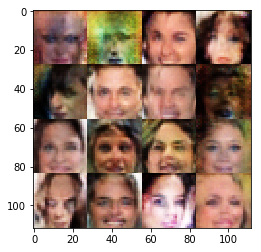

Epoch 1/1... Steps 2110:  Discriminator Loss: 1.2698... Generator Loss: 1.6756
Epoch 1/1... Steps 2120:  Discriminator Loss: 1.0314... Generator Loss: 0.8428
Epoch 1/1... Steps 2130:  Discriminator Loss: 1.2436... Generator Loss: 0.6251
Epoch 1/1... Steps 2140:  Discriminator Loss: 1.0825... Generator Loss: 1.1281
Epoch 1/1... Steps 2150:  Discriminator Loss: 0.9054... Generator Loss: 1.0718
Epoch 1/1... Steps 2160:  Discriminator Loss: 1.0960... Generator Loss: 0.9681
Epoch 1/1... Steps 2170:  Discriminator Loss: 1.3515... Generator Loss: 1.9038
Epoch 1/1... Steps 2180:  Discriminator Loss: 1.0537... Generator Loss: 1.0834
Epoch 1/1... Steps 2190:  Discriminator Loss: 1.3805... Generator Loss: 0.5186
Epoch 1/1... Steps 2200:  Discriminator Loss: 0.9821... Generator Loss: 1.4757
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



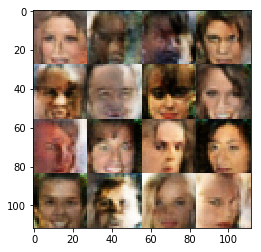

Epoch 1/1... Steps 2210:  Discriminator Loss: 1.1852... Generator Loss: 0.7976
Epoch 1/1... Steps 2220:  Discriminator Loss: 1.1226... Generator Loss: 1.2691
Epoch 1/1... Steps 2230:  Discriminator Loss: 1.1233... Generator Loss: 0.7618
Epoch 1/1... Steps 2240:  Discriminator Loss: 1.2697... Generator Loss: 0.6184
Epoch 1/1... Steps 2250:  Discriminator Loss: 1.2262... Generator Loss: 0.6423
Epoch 1/1... Steps 2260:  Discriminator Loss: 1.2279... Generator Loss: 0.6433
Epoch 1/1... Steps 2270:  Discriminator Loss: 0.9608... Generator Loss: 1.1299
Epoch 1/1... Steps 2280:  Discriminator Loss: 0.9500... Generator Loss: 1.2307
Epoch 1/1... Steps 2290:  Discriminator Loss: 1.0506... Generator Loss: 0.9646
Epoch 1/1... Steps 2300:  Discriminator Loss: 1.3690... Generator Loss: 0.5646
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



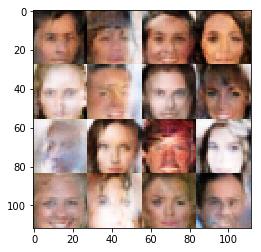

Epoch 1/1... Steps 2310:  Discriminator Loss: 1.2543... Generator Loss: 2.2418
Epoch 1/1... Steps 2320:  Discriminator Loss: 1.0848... Generator Loss: 0.8254
Epoch 1/1... Steps 2330:  Discriminator Loss: 1.3117... Generator Loss: 1.0229
Epoch 1/1... Steps 2340:  Discriminator Loss: 1.0576... Generator Loss: 0.8859
Epoch 1/1... Steps 2350:  Discriminator Loss: 1.2872... Generator Loss: 0.6277
Epoch 1/1... Steps 2360:  Discriminator Loss: 1.7906... Generator Loss: 0.3122
Epoch 1/1... Steps 2370:  Discriminator Loss: 1.1796... Generator Loss: 0.7115
Epoch 1/1... Steps 2380:  Discriminator Loss: 1.1938... Generator Loss: 1.0904
Epoch 1/1... Steps 2390:  Discriminator Loss: 1.2345... Generator Loss: 0.6355
Epoch 1/1... Steps 2400:  Discriminator Loss: 1.0966... Generator Loss: 0.7263
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



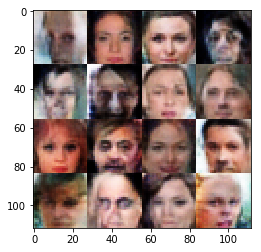

Epoch 1/1... Steps 2410:  Discriminator Loss: 1.7759... Generator Loss: 0.3266
Epoch 1/1... Steps 2420:  Discriminator Loss: 1.0443... Generator Loss: 1.0881
Epoch 1/1... Steps 2430:  Discriminator Loss: 1.0274... Generator Loss: 1.1931
Epoch 1/1... Steps 2440:  Discriminator Loss: 0.8654... Generator Loss: 1.3673
Epoch 1/1... Steps 2450:  Discriminator Loss: 1.3580... Generator Loss: 0.5538
Epoch 1/1... Steps 2460:  Discriminator Loss: 1.1899... Generator Loss: 0.6299
Epoch 1/1... Steps 2470:  Discriminator Loss: 1.3339... Generator Loss: 2.8108
Epoch 1/1... Steps 2480:  Discriminator Loss: 1.1637... Generator Loss: 1.5654
Epoch 1/1... Steps 2490:  Discriminator Loss: 1.1315... Generator Loss: 0.8298
Epoch 1/1... Steps 2500:  Discriminator Loss: 1.0704... Generator Loss: 0.7997
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



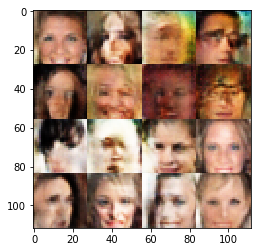

Epoch 1/1... Steps 2510:  Discriminator Loss: 1.4378... Generator Loss: 0.4893
Epoch 1/1... Steps 2520:  Discriminator Loss: 0.7827... Generator Loss: 1.6992
Epoch 1/1... Steps 2530:  Discriminator Loss: 1.1979... Generator Loss: 0.7150
Epoch 1/1... Steps 2540:  Discriminator Loss: 1.4184... Generator Loss: 0.5065
Epoch 1/1... Steps 2550:  Discriminator Loss: 1.1888... Generator Loss: 0.6403
Epoch 1/1... Steps 2560:  Discriminator Loss: 1.1462... Generator Loss: 0.7123
Epoch 1/1... Steps 2570:  Discriminator Loss: 1.7678... Generator Loss: 0.3147
Epoch 1/1... Steps 2580:  Discriminator Loss: 0.8991... Generator Loss: 1.1727
Epoch 1/1... Steps 2590:  Discriminator Loss: 1.3614... Generator Loss: 0.5259
Epoch 1/1... Steps 2600:  Discriminator Loss: 1.0787... Generator Loss: 1.0900
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



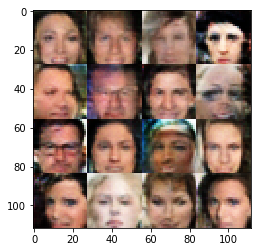

Epoch 1/1... Steps 2610:  Discriminator Loss: 0.8790... Generator Loss: 1.1393
Epoch 1/1... Steps 2620:  Discriminator Loss: 1.2980... Generator Loss: 0.5594
Epoch 1/1... Steps 2630:  Discriminator Loss: 0.8982... Generator Loss: 1.2341
Epoch 1/1... Steps 2640:  Discriminator Loss: 1.0662... Generator Loss: 1.0664
Epoch 1/1... Steps 2650:  Discriminator Loss: 1.1981... Generator Loss: 0.6782
Epoch 1/1... Steps 2660:  Discriminator Loss: 1.0515... Generator Loss: 1.0741
Epoch 1/1... Steps 2670:  Discriminator Loss: 1.0153... Generator Loss: 1.1572
Epoch 1/1... Steps 2680:  Discriminator Loss: 1.0656... Generator Loss: 1.0937
Epoch 1/1... Steps 2690:  Discriminator Loss: 1.1183... Generator Loss: 0.8079
Epoch 1/1... Steps 2700:  Discriminator Loss: 1.4814... Generator Loss: 0.4647
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



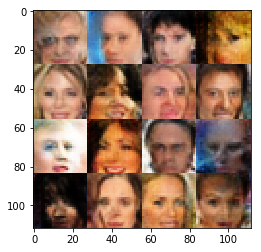

Epoch 1/1... Steps 2710:  Discriminator Loss: 1.1755... Generator Loss: 0.7242
Epoch 1/1... Steps 2720:  Discriminator Loss: 1.1862... Generator Loss: 2.0024
Epoch 1/1... Steps 2730:  Discriminator Loss: 1.1195... Generator Loss: 1.0020
Epoch 1/1... Steps 2740:  Discriminator Loss: 1.4292... Generator Loss: 0.5092
Epoch 1/1... Steps 2750:  Discriminator Loss: 1.0089... Generator Loss: 1.1449
Epoch 1/1... Steps 2760:  Discriminator Loss: 1.0083... Generator Loss: 1.2667
Epoch 1/1... Steps 2770:  Discriminator Loss: 1.0671... Generator Loss: 0.8916
Epoch 1/1... Steps 2780:  Discriminator Loss: 1.0095... Generator Loss: 1.6640
Epoch 1/1... Steps 2790:  Discriminator Loss: 1.0997... Generator Loss: 1.1911
Epoch 1/1... Steps 2800:  Discriminator Loss: 1.6428... Generator Loss: 0.3981
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



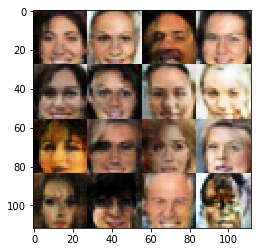

Epoch 1/1... Steps 2810:  Discriminator Loss: 1.1981... Generator Loss: 0.6728
Epoch 1/1... Steps 2820:  Discriminator Loss: 0.9946... Generator Loss: 1.2154
Epoch 1/1... Steps 2830:  Discriminator Loss: 1.0289... Generator Loss: 0.8630
Epoch 1/1... Steps 2840:  Discriminator Loss: 1.7504... Generator Loss: 0.3324
Epoch 1/1... Steps 2850:  Discriminator Loss: 1.3656... Generator Loss: 1.5698
Epoch 1/1... Steps 2860:  Discriminator Loss: 1.5631... Generator Loss: 0.4024
Epoch 1/1... Steps 2870:  Discriminator Loss: 1.0588... Generator Loss: 1.1457
Epoch 1/1... Steps 2880:  Discriminator Loss: 1.4245... Generator Loss: 0.4994
Epoch 1/1... Steps 2890:  Discriminator Loss: 0.9816... Generator Loss: 0.9843
Epoch 1/1... Steps 2900:  Discriminator Loss: 1.6260... Generator Loss: 0.3789
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



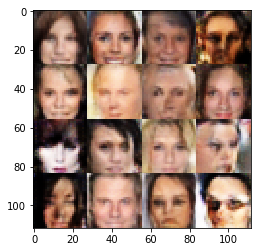

Epoch 1/1... Steps 2910:  Discriminator Loss: 1.0813... Generator Loss: 1.3471
Epoch 1/1... Steps 2920:  Discriminator Loss: 1.4276... Generator Loss: 0.5690
Epoch 1/1... Steps 2930:  Discriminator Loss: 1.2282... Generator Loss: 0.6360
Epoch 1/1... Steps 2940:  Discriminator Loss: 1.0026... Generator Loss: 1.0945
Epoch 1/1... Steps 2950:  Discriminator Loss: 1.1111... Generator Loss: 0.8264
Epoch 1/1... Steps 2960:  Discriminator Loss: 1.3133... Generator Loss: 0.5722
Epoch 1/1... Steps 2970:  Discriminator Loss: 1.0945... Generator Loss: 0.8009
Epoch 1/1... Steps 2980:  Discriminator Loss: 1.0420... Generator Loss: 1.0876
Epoch 1/1... Steps 2990:  Discriminator Loss: 1.5480... Generator Loss: 0.4528
Epoch 1/1... Steps 3000:  Discriminator Loss: 0.9526... Generator Loss: 1.0481
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



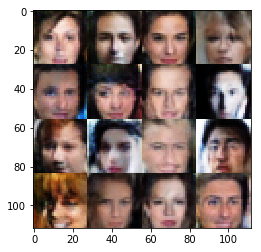

Epoch 1/1... Steps 3010:  Discriminator Loss: 1.1604... Generator Loss: 0.6958
Epoch 1/1... Steps 3020:  Discriminator Loss: 1.4274... Generator Loss: 0.4954
Epoch 1/1... Steps 3030:  Discriminator Loss: 1.5372... Generator Loss: 0.4353
Epoch 1/1... Steps 3040:  Discriminator Loss: 1.2310... Generator Loss: 0.6572
Epoch 1/1... Steps 3050:  Discriminator Loss: 1.5463... Generator Loss: 0.4196
Epoch 1/1... Steps 3060:  Discriminator Loss: 1.0496... Generator Loss: 1.2776
Epoch 1/1... Steps 3070:  Discriminator Loss: 0.9863... Generator Loss: 1.2107
Epoch 1/1... Steps 3080:  Discriminator Loss: 1.2350... Generator Loss: 0.7303
Epoch 1/1... Steps 3090:  Discriminator Loss: 1.1322... Generator Loss: 1.3395
Epoch 1/1... Steps 3100:  Discriminator Loss: 1.2320... Generator Loss: 0.6476
------------
 Generator
 ------------

Dense (?, 7, 7, 256)
Conv1 -  (?, 14, 14, 128)
Conv2 -  (?, 28, 28, 64)
Logits -  (?, 28, 28, 3) 



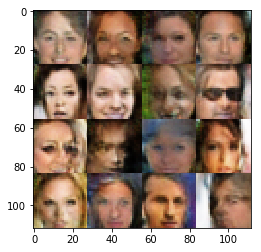

Epoch 1/1... Steps 3110:  Discriminator Loss: 1.3701... Generator Loss: 0.7932
Epoch 1/1... Steps 3120:  Discriminator Loss: 1.2254... Generator Loss: 0.6446
Epoch 1/1... Steps 3130:  Discriminator Loss: 1.0423... Generator Loss: 1.0505
Epoch 1/1... Steps 3140:  Discriminator Loss: 1.3433... Generator Loss: 0.7178
Epoch 1/1... Steps 3150:  Discriminator Loss: 1.1416... Generator Loss: 0.8881
Epoch 1/1... Steps 3160:  Discriminator Loss: 1.1222... Generator Loss: 0.8752


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5
alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.